In [4]:
from genericpath import exists
from random import Random
from typing import List, Dict, Any
from numpy.core.records import array
import torch
import json
import pandas as pd
import copy
import random
from tqdm.auto import tqdm
from pathlib import Path

import spacy
from spacy.lang.en import English
from spacy.tokens.token import Token
import argparse
import pandas as pd
from collections import Counter
import copy
import random
from scipy.special import softmax
import argparse
import yaml
from addict import Dict

import numpy as np
#from common import load_json, load_jsonl, save_jsonl

from transformers import AutoTokenizer, AutoModel
import torch
import sys
import json_lines

C:\Users\mikad\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mikad\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\mikad\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [14]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
device = torch.device('cpu')

#train & valid & test are in txt files
def load_file(filepath, mode='jsonl'):
    with open(filepath, 'r') as outfile:
        url_to_code = {}
        if mode == 'jsonl':
            for line in outfile:
                line = line.strip()
                js = json.loads(line)

                url_to_code[js['idx']] = js['func']

            return url_to_code
        elif mode == 'txt':
            #array of tuples
            lines = outfile.read().splitlines()
            file = []
            for l in lines:
                tokens = l.split('\t')
                file.append( ((tokens[0], tokens[1]), tokens[2]) )
            return file

def load_code_label(filepath, url_to_code):
    data=[]
    positive_count = 0
    negative_count = 0

    individual_code = []
    pb1 = tqdm(total=2000)
    with open(filepath) as f:
        for line in f:
            line=line.strip()
            url1,url2,label=line.split('\t')

            if (positive_count > 500) and (negative_count > 500):
                break

            if (url1 in list(url_to_code.keys())) and (url2 in list(url_to_code.keys())):
                if label=='0':
                    label=0
                else:
                    label=1

                if label == 1 and positive_count <= 500:
                    data.append((url1,url2,label))
                    individual_code.append(url1)
                    individual_code.append(url2)

                    positive_count += 1

                    pb1.update(1)

                elif label == 0 and negative_count <= 500:
                    data.append((url1,url2,label))
                    individual_code.append(url1)
                    individual_code.append(url2)

                    negative_count += 1

                    pb1.update(1)
        pb1.close()
        individual_code = list(np.unique(individual_code))
    return data, individual_code
"Load the dataset"
url_to_code = load_file("D:\\School\\Winter 2022\\Comp 599\\CodeXGLUE-main\\CodeXGLUE-main\\Code-Code\\Clone-detection-BigCloneBench\\dataset\\data.jsonl")

"Get only the code that's shorter than 510 tokens"
def get_short_code(code_dict: dict) -> list:
    short_code = {}
    n = 0
    for i in list(code_dict.keys()):
        with torch.no_grad():
            code_tokens=tokenizer.tokenize(code_dict[i])
        if len(code_tokens) <= 512:
            short_code[i] = code_dict[i]
    return short_code

url_to_code_short = get_short_code(url_to_code)

data_idx, ind_code = load_code_label(
    filepath="D:\\School\\Winter 2022\\Comp 599\\CodeXGLUE-main\\CodeXGLUE-main\\Code-Code\\Clone-detection-BigCloneBench\\dataset\\test.txt",
    url_to_code=url_to_code_short
)

print('okay')

Token indices sequence length is longer than the specified maximum sequence length for this model (5942 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/2000 [00:00<?, ?it/s]

okay


In [15]:
print(len(list(url_to_code_short.keys())))
print(len(data_idx))
print(ind_code)

4962
1002
['10131427', '10176678', '10214218', '10218878', '10281203', '10361370', '10385815', '10391753', '10436471', '10445819', '10504714', '10547671', '10674824', '10715601', '10728243', '10795866', '1097146', '1097147', '11005804', '11032546', '11153282', '11154758', '11305840', '1133123', '11334468', '11377441', '1141361', '11475527', '11477906', '11484416', '11562165', '11562173', '11616716', '11716816', '11865906', '1188100', '11933797', '11952735', '11962480', '11968328', '12004824', '12034046', '12039034', '12055086', '12085127', '12097948', '12106167', '12128591', '12171364', '12172485', '12197169', '12236729', '12242903', '12306305', '12349563', '1235538', '12380475', '12417893', '12454178', '12579075', '12783713', '12869602', '12883117', '13012591', '13024538', '13063241', '13122204', '13233761', '13368520', '13414771', '13421722', '13439950', '13499897', '13565787', '1357662', '13595251', '1362', '13644374', '13644375', '13783549', '13783898', '13891080', '13946197', '139

In [16]:
filepath = 'D:\\School\\Winter 2022\\Comp 599\\indx_test.txt'
i = 0
with open(filepath, 'w+') as f:
    for (url1, url2, label) in data_idx:
        if (url1 in list(url_to_code_short.keys())) and (url2 in list(url_to_code_short.keys())):
            i += 1
            f.write(f'{url1}\t{url2}\t{label}\n')
print(i)

1002


In [54]:
i = 0
for k, v in url_to_code_short.items():
    with open(f'Java Code Sample Mika\\{k}.txt', 'w') as text_file:
        try:
            text_file.write(v)
            i += 1
        except:
            pass
print(i)

KeyboardInterrupt: 

In [5]:
# tokenizes the dataset
def tokenize(code : str) -> list:
  with torch.no_grad():
    code_tokens=tokenizer.tokenize(code)

    if len(code_tokens) >= 512: #confirm tokes arent too big for model
      return None
    return code_tokens

In [17]:
# tokenizes the dataset
def tokenize(code : str) -> list:
  with torch.no_grad():
    code_tokens=tokenizer.tokenize(code)

    if len(code_tokens) >= 512: #confirm tokes arent too big for model
      return None
    return code_tokens

def randomize(
    sent:str,
    retain_punct: bool,
    retain_position:bool,
    percent : float,
    keep_order:float,
    tokenizer,
    seed,
):

    random.seed(seed)
    tok = tokenizer.tokenize(sent)
    original = copy.deepcopy(tok)
    # modify this with the new one at the end and do some padding

    num_to_keep = int(len(tok) * keep_order)
    mask = [True for i in range(len(tok))]
    if keep_order > 0 and num_to_keep > 0:
        if num_to_keep == len(tok):
            raise AssertionError("Cannot shuffle if all words are kept")
        start_id_to_keep = random.choice(range(0, len(tok) - num_to_keep))
        end_id_to_keep = start_id_to_keep + num_to_keep
        mask = [False if ((i >= start_id_to_keep) and (i <= end_id_to_keep)) else True for i in range(len(tok))]

        kept_order = True
    idx_to_shuffle = [i for i,m in enumerate(mask) if m]
    random.shuffle(idx_to_shuffle)

    shuffled_sentence_idx = []
    x = 0
    # here you're keeping sequence order & position
    for i, m in enumerate(mask):
        if m:
            shuffled_sentence_idx.append(idx_to_shuffle[i - x])
        else:
            shuffled_sentence_idx.append(i)
            x += 1
    shuffled_sentence = [tok[i] for i in shuffled_sentence_idx]

    # prepare shuffled sentence
    shuffled_sentence += [tokenizer.pad_token] *  (512 - len(shuffled_sentence))
    tokens_shuffled_sentence = [tokenizer.cls_token] + shuffled_sentence + [tokenizer.sep_token]
    tokens_ids_shuffled_sentence = tokenizer.convert_tokens_to_ids(tokens_shuffled_sentence)
    #tokens_ids_shuffled_sentence = torch.tensor(tokens_ids_shuffled_sentence)[None, :]

    #original
    original += [tokenizer.pad_token] *  (512 - len(original))
    tokens_original = [tokenizer.cls_token] + original + [tokenizer.sep_token]
    tokens_ids_original = tokenizer.convert_tokens_to_ids(tokens_original)
    #tokens_ids_original = torch.tensor(tokens_ids_original)[None, :]

    return tokens_ids_shuffled_sentence, tokens_ids_original, mask

def shuffle_data(
    data : dict,
    tokenizer,
    retain_punct = False,
    num_tries=50,
    percent=1.0
):
    pb = tqdm(total=len(data))
    shuffled_data = {}
    for k, v in data.items():
        ## TODO: Compute the number of possible permutations
        code = v
        # seed: 0 -> 100 (default)
        shuffled_data[k] = {}
        shuffled_data[k]['shuffled'] = {}
        for keep_order in [0]:
            shuffled_data[k]['shuffled'][f'{keep_order}'] = []
            for seed in range(num_tries):
                s1, original, _ = randomize(
                    code, #this is the sentence to shuffle
                    seed=seed,
                    retain_punct=retain_punct,
                    retain_position=True,
                    keep_order=0,
                    percent=percent,
                    tokenizer=tokenizer,
                    )
                if not('original' in list(shuffled_data[k].keys())):
                    shuffled_data[k]['original'] = original
                shuffled_data[k]['shuffled'][f'{keep_order}'].append(s1)
        pb.update(1)
    pb.close()
    return shuffled_data

shuffled_data = shuffle_data(
    data=url_to_code_short,
    tokenizer=tokenizer
)

with open('D:\\School\\Winter 2022\\Comp 599\\json_data.json', 'w') as outfile:
    json.dump(shuffled_data, outfile)

  0%|          | 0/4962 [00:00<?, ?it/s]

In [ ]:
with open('D:\\School\\Winter 2022\\Comp 599\\json_data.json', 'w') as outfile:
    json.dump(shuffled_data, outfile)

# Create some new data

In [18]:
with open("D:\\School\\Winter 2022\\Comp 599\\json_experiment.json", 'r') as f:
    data = r'' + f.read()

    data_json_experiment = json.loads(data)

In [77]:
import matplotlib.pyplot as plt

def get_prediction(pre:list):
    i = pre[0]
    i0 = i[0]
    i1 = i[1]

    if i0 > i1:
        return 0
    else:
        return 1

shuffled_accuracy = [data_json_experiment[k]['0'][0] for k in data_json_experiment.keys()]
shuffled_accuracy_low = [data_json_experiment[k]['0'][0] for k in data_json_experiment.keys() if data_json_experiment[k]['0'][0] < 0.9]

shuffled_accuracy_correct = [data_json_experiment[k]['0'][0] for k in data_json_experiment.keys() if get_prediction(data_json_experiment[k]['original']) == int(k[2])]
shuffled_accuracy_correct_low = [data_json_experiment[k]['0'][0] for k in data_json_experiment.keys() if get_prediction(data_json_experiment[k]['original']) == k[2] and data_json_experiment[k]['0'][0] < 0.9]

shuffled_accuracy_incorrect = [data_json_experiment[k]['0'][0] for k in data_json_experiment.keys() if not get_prediction(data_json_experiment[k]['original']) == int(k[2])]
shuffled_accuracy_incorrect_low = [data_json_experiment[k]['0'][0] for k in data_json_experiment.keys() if not get_prediction(data_json_experiment[k]['original']) == k[2] and data_json_experiment[k]['0'][0] < 0.9]

In [104]:
def return_stats(results:list):
    if not(len(results) == 0):
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        n = len(results)
        predicted = None
        label = None

        out = {}

        for i in results:
            label = i['label']
            predicted = i['predicted']
            accuracy = i['accuracy']
            if label == 0:
                tn += 30 * accuracy
                fp += 30 * (1-accuracy)

            elif label == 1:
                tp += 30 * accuracy
                fn += 30 * (1-accuracy)

        out['tp'] =  (tp/n)/30
        out['fp'] = (fp/n)/30
        out['fn'] = (fn/n)/30
        out['tn'] = (tn/n)/30
        out['predicted'] = predicted
        out['label'] = label
        out['n'] = n

        return out
    else:
        return None

In [88]:
shuffled_predicted_0_label_0 = [{'label': data_json_experiment[k]['label'], 'predicted': get_prediction(data_json_experiment[k]['original']), 'accuracy': data_json_experiment[k]['0'][0]} for k in data_json_experiment.keys() if (data_json_experiment[k]['label'] == 0) and (get_prediction(data_json_experiment[k]['original'])) == 0]
shuffled_predicted_1_label_0 = [{'label': data_json_experiment[k]['label'], 'predicted': get_prediction(data_json_experiment[k]['original']), 'accuracy': data_json_experiment[k]['0'][0]} for k in data_json_experiment.keys() if (data_json_experiment[k]['label'] == 0) and (get_prediction(data_json_experiment[k]['original'])) == 1]

shuffled_predicted_1_label_1 = [{'label': data_json_experiment[k]['label'], 'predicted': get_prediction(data_json_experiment[k]['original']), 'accuracy': data_json_experiment[k]['0'][0]} for k in data_json_experiment.keys() if data_json_experiment[k]['label'] == 1 and (get_prediction(data_json_experiment[k]['original'])) == 1]
shuffled_predicted_0_label_1 = [{'label': data_json_experiment[k]['label'], 'predicted': get_prediction(data_json_experiment[k]['original']), 'accuracy': data_json_experiment[k]['0'][0]} for k in data_json_experiment.keys() if data_json_experiment[k]['label'] == 1 and (get_prediction(data_json_experiment[k]['original'])) == 0]

In [105]:
predicted_0_label_0 = return_stats(shuffled_predicted_0_label_0)
predicted_1_label_0 = return_stats(shuffled_predicted_1_label_0)
predicted_1_label_1 = return_stats(shuffled_predicted_1_label_1)
predicted_0_label_1 = return_stats(shuffled_predicted_0_label_1)

In [106]:
for k, v in predicted_0_label_0.items():
    print(f'{k}: {v}')
print('-------------------')
for k, v in predicted_1_label_1.items():
    print(f'{k}: {v}')
print('-------------------')
for k, v in predicted_0_label_1.items():
    print(f'{k}: {v}')
print('-------------------')

tp: 0.0
fp: 0.008380566801619428
fn: 0.0
tn: 0.9916194331983804
predicted: 0
label: 0
n: 494
-------------------
tp: 0.8114634146341458
fp: 0.0
fn: 0.1885365853658536
tn: 0.0
predicted: 1
label: 1
n: 492
-------------------
tp: 0.01111111111111111
fp: 0.0
fn: 0.9888888888888889
tn: 0.0
predicted: 0
label: 1
n: 9
-------------------


In [83]:
#print(len(data_json_experiment.keys()))
print(len(shuffled_predicted_0_label_0))
print(len(shuffled_predicted_1_label_0))

print(len(shuffled_predicted_1_label_1))
print(len(shuffled_predicted_0_label_1))

494
0
492
9


(array([  2.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.,   2.,   1., 485.]),
 array([0.22 , 0.272, 0.324, 0.376, 0.428, 0.48 , 0.532, 0.584, 0.636,
        0.688, 0.74 , 0.792, 0.844, 0.896, 0.948, 1.   ]),
 <a list of 15 Patch objects>)

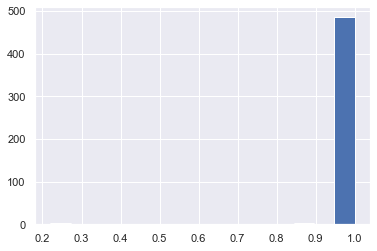

In [79]:
plt.hist (shuffled_true_label_0, bins=15)

(array([ 47.,   7.,   5.,  10.,   4.,   0.,   2.,   4.,   4.,  20.,   5.,
         16.,  21.,  14., 333.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 <a list of 15 Patch objects>)

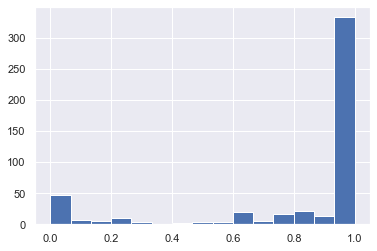

In [80]:
plt.hist (shuffled_true_label_1, bins=15)

C:\Users\mikad\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
C:\Users\mikad\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'title')

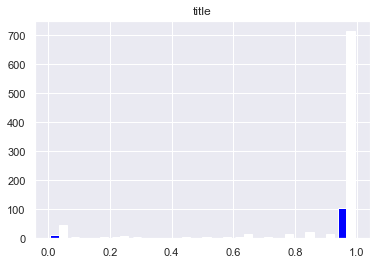

In [64]:
plt.hist ([shuffled_accuracy_correct, shuffled_accuracy_incorrect], color=['blue', 'white'], label=['1', '2'],bins=15)
plt.title('title')

In [ ]:
plt.hist ([shuffled_accuracy_low, shuffled_accuracy_correct

(array([[56., 11., 13.,  5.,  0.,  7., 15., 12., 19., 27.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [56., 11., 13.,  5.,  0.,  7., 15., 12., 19., 27.]]),
 array([0.   , 0.088, 0.176, 0.264, 0.352, 0.44 , 0.528, 0.616, 0.704,
        0.792, 0.88 ]),
 <a list of 3 Lists of Patches objects>)

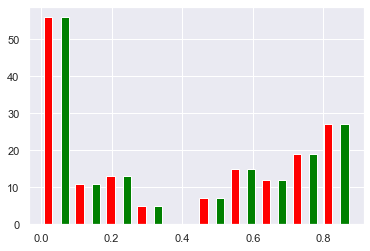

In [51]:
plt.hist ([shuffled_accuracy_low, shuffled_accuracy_correct_low, shuffled_accuracy_incorrect_low], color=['red', 'blue', 'green'], bins=10)

C:\Users\mikad\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\mikad\anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


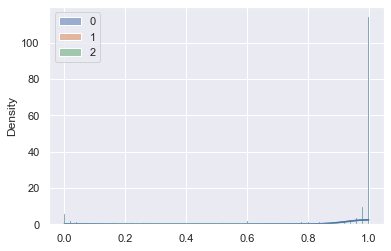

In [42]:
import seaborn as sns
sns.set_theme(style='darkgrid')
sns.histplot([shuffled_accuracy, shuffled_accuracy_correct, shuffled_accuracy_incorrect], kde=True, stat='density')